In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from utils import load_ckpt, print_colored
from tokenizer import make_tokenizer
from model import get_hertz_dev_config
import matplotlib.pyplot as plt
from IPython.display import Audio, display


# If you get an error like "undefined symbol: __nvJitLinkComplete_12_4, version libnvJitLink.so.12",
# you need to install PyTorch with the correct CUDA version. Run:
# `pip3 uninstall torch torchaudio && pip3 install torch torchaudio --index-url https://download.pytorch.org/whl/cu121`

device = 'cuda' if T.cuda.is_available() else 'cpu'
T.cuda.set_device(1)
print_colored(f"Using device: {device}", "grey")

Using device: cuda


In [3]:
# This code will automatically download them if it can't find them.
audio_tokenizer = make_tokenizer(device)

Loading checkpoint from repo_id si-pbc/hertz-dev and filename inference_apatosaurus_95000.pt. This may take a while...
Downloaded checkpoint to /home/galen/.cache/huggingface/hub/models--si-pbc--hertz-dev/snapshots/3571274bd8dbbb0522fb6c8361926cb80475f3e3/inference_apatosaurus_95000.pt
Loaded checkpoint from /home/galen/.cache/huggingface/hub/models--si-pbc--hertz-dev/snapshots/3571274bd8dbbb0522fb6c8361926cb80475f3e3/inference_apatosaurus_95000.pt
Loaded tokenizer state dict: _IncompatibleKeys(missing_keys=[], unexpected_keys=['recon_metric.metrics.0.window', 'encoder.res_stack.0.pad_buffer', 'encoder.res_stack.1.res_block.0.conv1.pad_buffer', 'encoder.res_stack.1.res_block.1.conv1.pad_buffer', 'encoder.res_stack.1.res_block.2.conv1.pad_buffer', 'encoder.res_stack.1.res_block.3.pad_buffer', 'encoder.res_stack.2.res_block.0.conv1.pad_buffer', 'encoder.res_stack.2.res_block.1.conv1.pad_buffer', 'encoder.res_stack.2.res_block.2.conv1.pad_buffer', 'encoder.res_stack.2.res_block.3.pad_buff

In [4]:
# We have different checkpoints for the single-speaker and two-speaker models
# Set to True to load and run inference with the two-speaker model
TWO_SPEAKER = False
USE_PURE_AUDIO_ABLATION = False # We trained a base model with no text initialization at all. Toggle this to enable it.
assert not (USE_PURE_AUDIO_ABLATION and TWO_SPEAKER) # We only have a single-speaker version of this model.


In [5]:
model_config = get_hertz_dev_config(is_split=TWO_SPEAKER, use_pure_audio_ablation=USE_PURE_AUDIO_ABLATION)

generator = model_config()
generator = generator.eval().to(T.bfloat16).to(device)

Loading checkpoint from repo_id si-pbc/hertz-dev and filename inference_caraway_112000.pt. This may take a while...
Downloaded checkpoint to /home/galen/.cache/huggingface/hub/models--si-pbc--hertz-dev/snapshots/3571274bd8dbbb0522fb6c8361926cb80475f3e3/inference_caraway_112000.pt
Loaded checkpoint from /home/galen/.cache/huggingface/hub/models--si-pbc--hertz-dev/snapshots/3571274bd8dbbb0522fb6c8361926cb80475f3e3/inference_caraway_112000.pt
<All keys matched successfully>
Loading checkpoint from repo_id si-pbc/hertz-dev and filename inference_whip_72000.pt. This may take a while...
Downloaded checkpoint to /home/galen/.cache/huggingface/hub/models--si-pbc--hertz-dev/snapshots/3571274bd8dbbb0522fb6c8361926cb80475f3e3/inference_whip_72000.pt
Loaded checkpoint from /home/galen/.cache/huggingface/hub/models--si-pbc--hertz-dev/snapshots/3571274bd8dbbb0522fb6c8361926cb80475f3e3/inference_whip_72000.pt
<All keys matched successfully>
Loading checkpoint from repo_id si-pbc/hertz-dev and filenam

Loading and preprocessing audio...
Loaded audio shape: torch.Size([1, 832351])
Resampling from 48000Hz to 16000Hz...
Audio preprocessing complete!


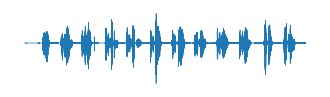

Audio ready for playback ↑
torch.Size([1, 1, 277451])
Prompt length: 17.00s


In [10]:
def load_and_preprocess_audio(audio_path):
    print_colored("Loading and preprocessing audio...", "blue", bold=True)
    # Load audio file
    audio_tensor, sr = torchaudio.load(audio_path)
    print_colored(f"Loaded audio shape: {audio_tensor.shape}", "grey")
    
    if TWO_SPEAKER:
        if audio_tensor.shape[0] == 1:
            print_colored("Converting mono to stereo...", "grey")
            audio_tensor = audio_tensor.repeat(2, 1)
            print_colored(f"Stereo audio shape: {audio_tensor.shape}", "grey")
    else:
        if audio_tensor.shape[0] == 2:
            print_colored("Converting stereo to mono...", "grey")
            audio_tensor = audio_tensor.mean(dim=0).unsqueeze(0)
            print_colored(f"Mono audio shape: {audio_tensor.shape}", "grey")
        
    # Resample to 16kHz if needed
    if sr != 16000:
        print_colored(f"Resampling from {sr}Hz to 16000Hz...", "grey")
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        audio_tensor = resampler(audio_tensor)
        
    # Clip to 5 minutes if needed
    max_samples = 16000 * 60 * 5
    if audio_tensor.shape[1] > max_samples:
        print_colored("Clipping audio to 5 minutes...", "grey")
        audio_tensor = audio_tensor[:, :max_samples]

    
    print_colored("Audio preprocessing complete!", "green")
    return audio_tensor.unsqueeze(0)

def display_audio(audio_tensor):
    audio_tensor = audio_tensor.cpu().squeeze()
    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)
    audio_tensor = audio_tensor.float()

    # Make a waveform plot
    plt.figure(figsize=(4, 1))
    plt.plot(audio_tensor.numpy()[0], linewidth=0.5)
    plt.axis('off')
    plt.show()

    # Make an audio player
    display(Audio(audio_tensor.numpy(), rate=16000))
    print_colored(f"Audio ready for playback ↑", "green", bold=True)
    
    

# Our model is very prompt-sensitive, so we recommend experimenting with a diverse set of prompts.
prompt_audio = load_and_preprocess_audio('./prompts/countdown_mono.wav')
display_audio(prompt_audio)
print(prompt_audio.shape)
prompt_len_seconds = prompt_audio.shape[-1] // 16000
print_colored(f"Prompt length: {prompt_len_seconds:.2f}s", "grey")
prompt_len = prompt_len_seconds * 8

In [11]:
print_colored("Encoding prompt...", "blue")
with T.autocast(device_type='cuda', dtype=T.bfloat16):
    if TWO_SPEAKER:
        encoded_prompt_audio_ch1 = audio_tokenizer.latent_from_data(prompt_audio[:, 0:1].to(device))
        encoded_prompt_audio_ch2 = audio_tokenizer.latent_from_data(prompt_audio[:, 1:2].to(device))
        encoded_prompt_audio = T.cat([encoded_prompt_audio_ch1, encoded_prompt_audio_ch2], dim=-1)
    else:
        encoded_prompt_audio = audio_tokenizer.latent_from_data(prompt_audio.to(device))
print_colored(f"Encoded prompt shape: {encoded_prompt_audio.shape}", "grey")
print_colored("Prompt encoded successfully!", "green")

Encoding prompt...
Encoded prompt shape: torch.Size([1, 138, 32])
Prompt encoded successfully!


In [ ]:
def get_completion(encoded_prompt_audio, prompt_len, gen_len=None, num_completions=1):
    prompt_len_seconds = prompt_len / 8
    print_colored(f"Prompt length: {prompt_len_seconds:.2f}s", "grey")
    print_colored("Completing audio...", "blue")
    encoded_prompt_audio = encoded_prompt_audio[:, :prompt_len]
    with T.autocast(device_type='cuda', dtype=T.bfloat16):
        completed_audio_batch = generator.completion(
            encoded_prompt_audio, 
            temps=(.8, (0.5, 0.1)), # (token_temp, (categorical_temp, gaussian_temp))
            use_cache=True,
            gen_len=gen_len,
            num_completions=num_completions
        )

        completed_audio = completed_audio_batch
        print_colored(f"Decoding completion...", "blue")
        if TWO_SPEAKER:
            decoded_completion_ch1 = audio_tokenizer.data_from_latent(completed_audio[:, :, :32].bfloat16())
            decoded_completion_ch2 = audio_tokenizer.data_from_latent(completed_audio[:, :, 32:].bfloat16())
            decoded_completion = T.cat([decoded_completion_ch1, decoded_completion_ch2], dim=0)
        else:
            decoded_completion = audio_tokenizer.data_from_latent(completed_audio.bfloat16())
        print_colored(f"Decoded completion shape: {decoded_completion.shape}", "grey")

    print_colored("Preparing audio for playback...", "blue")

    audio_tensor = decoded_completion.cpu().squeeze()
    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)
    audio_tensor = audio_tensor.float()

    if audio_tensor.abs().max() > 1:
        audio_tensor = audio_tensor / audio_tensor.abs().max()

    return audio_tensor[:, max(prompt_len*2000 - 16000, 0):]

num_completions = 10
print_colored(f"Generating {num_completions} completions...", "blue")
# for _ in range(num_completions):
completion_batch = get_completion(encoded_prompt_audio, prompt_len, gen_len=5*8, num_completions=num_completions) # 20 seconds of generation
for _ in range(5):
    for completion in completion_batch:
        display_audio(completion)
